In [5]:
import pandas as pd
import numpy as np
import importlib

import archs4py as a4

importlib.reload(a4)
a4.reload()

In [7]:
processed_gsm = a4.db.processed_gsms()
srr = a4.sra.get_gsms()

c:\Users\Rubberchicken\Documents\GitHub\archs4py\archs4py\sra.py:26: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  return read()


In [10]:
new_samples = a4.geo.scan_platforms(srr, processed_gsm)

100%|██████████| 22/22 [44:51<00:00, 122.32s/it]


In [12]:
new_samples.shape[0]

0

In [ ]:
if new_samples.shape[0] > 0:
    maxlistid = a4.db.get_max_id()
    gsm_meta = new_samples
    gsm_meta["listid"] = list(range(maxlistid+1, maxlistid+gsm_meta.shape[0]+1))
    sample_mapping = gsm_meta.loc[:, ["gse", "gsm", "sra", "listid"]]
    sample_mapping = sample_mapping.sort_values("gse").reset_index(drop=True)
    a4.db.add_mapping(sample_mapping)
    a4.db.add_sequencing_jobs(new_samples)

,gse,gsm,sra,listid
0,GSE100064,GSM2670741,SRR5687234,1583729
1,GSE100064,GSM2670740,SRR5687233,1583728
2,GSE100391,GSM2680090,SRR5750314,1583730
3,GSE100391,GSM2680182,SRR5750406,1647514
4,GSE100391,GSM2680181,SRR5750405,1647513
...,...,...,...,...
290052,GSE98548,GSM2598508,SRR5508144,1556867
290053,GSE98548,GSM2598507,SRR5508143,1556866
290054,GSE98548,GSM2598506,SRR5508142,1556865
290055,GSE98548,GSM2598505,SRR5508141,1556864


In [26]:
import pandas as pd
import numpy as np
import gzip

f=gzip.open('downloads/soft/GPL15103.soft.gz','rb')
soft=f.read()
f.close()

In [22]:
import os
os.system("zgrep '!Platform_sample_id|!Library_strategy' downloads/soft/GPL11154.soft.gz > test.tsv")
os.system("sed -i 's/!Platform_sample_id = //g' test.tsv")

1

In [33]:
import os
import pandas as pd

#os.system("zgrep '\^SAMPLE\|!Sample_library_strategy\|!Sample_tax' downloads/soft/GPL11154.soft.gz > temp.tsv")
os.system("zgrep '\^SAMPLE\|!Sample_library_strategy' downloads/soft/GPL11154.soft.gz > temp.tsv")

def chunk(l, n):
    return [l[i:i+n] for i in range(0, len(l), n)]

f=open('temp.tsv','r')
lines = f.readlines()
f.close()

lines = [x.strip().replace("^SAMPLE = ", "") for x in lines]
lines = [x.replace("!Sample_library_strategy = ", "") for x in lines]
lines = [x.replace("!Sample_taxid_ch1 = ", "") for x in lines]

cc = chunk(lines,2)
df = pd.DataFrame(cc)
rna_samples = df[df[1] == "RNA-Seq"][0]
newrnaseq = list(set(rna_samples).intersection(srr.index))

diff_samples= set(newrnaseq).difference(set(processed_gsm))

newrnaseq

28         GSM678412
29         GSM678413
30         GSM678414
63         GSM741170
64         GSM741171
             ...    
153228    GSM5577337
153229    GSM5580099
153230    GSM5580100
153231    GSM5580101
153232    GSM5580102
Name: 0, Length: 103124, dtype: object

In [38]:
len(set(rna_samples).intersection(srr.index))

88429

In [28]:
import tqdm
import urllib
import time
from collections import Counter


def chunk(l, n):
    return [l[i:i+n] for i in range(0, len(l), n)]

def fast_geo(platform, srr, processed_gsms):
    os.makedirs("downloads/soft", exist_ok=True)
    p = platform
    p1 =  p[0:5]+"nnn"
    p2 = p[0:9]
    url = "ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/"+p1+"/"+p2+"/soft/"+p2+"_family.soft.gz"
    urllib.request.urlretrieve(url, "downloads/soft/"+p2+".soft.gz")
    os.system("zgrep '\^SAMPLE\|!Sample_library_strategy' downloads/soft/"+p2+".soft.gz > temp.tsv")
    f=open('temp.tsv','r')
    lines = f.readlines()
    f.close()
    lines = [x.strip().replace("^SAMPLE = ", "") for x in lines]
    lines = [x.replace("!Sample_library_strategy = ", "") for x in lines]
    cc = chunk(lines,2)
    df = pd.DataFrame(cc)
    rna_samples = df[df[1] == "RNA-Seq"][0]
    news = set(rna_samples).intersection(srr.index).difference(set(processed_gsms[0]))
    os.system("zgrep '^!Sample_taxid_ch1' downloads/soft/"+p2+".soft.gz > temp.tsv")
    f=open('temp.tsv','r')
    lines = f.readlines()
    lines = [x.strip().replace("!Sample_taxid_ch1 = ", "") for x in lines]
    f.close()
    species = list(Counter(lines).keys())[0]
    os.system("zgrep '\^SAMPLE\|!Sample_series_id' downloads/soft/"+p2+".soft.gz > temp.tsv")
    f=open('temp.tsv','r')
    lines = f.readlines()
    f.close()
    sample_series = []
    sample = ""
    series = []
    for l in lines:
        if l.startswith("^SAMPLE"):
            if not sample == "":
                series = ",".join(series)
                sample_series.append([series, sample, species])
            sample = l.strip().replace("^SAMPLE = ", "")
            series = []
        else:
            series.append(l.strip().replace("!Sample_series_id = ", ""))
    sample_series = pd.DataFrame(sample_series)
    srna = set(rna_samples)
    idx = [i for i,e in enumerate(sample_series[1]) if e in srna]
    return sample_series.iloc[idx, :]

st = time.time()
platforms = ["GPL24676", "GPL24247", "GPL21626", "GPL21697", "GPL21273", "GPL20795", "GPL21493", "GPL21103", "GPL19057", "GPL18480", "GPL17021", "GPL15103", "GPL13112", "GPL21290", "GPL20301", "GPL18573", "GPL18460", "GPL16791", "GPL15433", "GPL11154", "GPL23227", "GPL23479"]
platform_results = []
for p in tqdm.tqdm(platforms):
    res = fast_geo(p, srr, processed_gsm)
    platform_results.append(res)

print(time.time() - st)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [25]:
os.system("zgrep '^!Sample_taxid_ch1' downloads/soft/GPL21273.soft.gz > temp.tsv")
f=open('temp.tsv','r')
lines = f.readlines()
lines = [x.strip().replace("!Sample_taxid_ch1 = ", "") for x in lines]
f.close()
list(Counter(lines).keys())[0]

'c:\\Users\\Rubberchicken\\Documents\\GitHub\\archs4py'

In [4]:
import subprocess, threading

class Command(object):
    def __init__(self, cmd):
        self.cmd = cmd
        self.process = None
    def run(self, timeout):
        def target():
            print('Thread started')
            f = open("thread.txt", "w")
            self.process = subprocess.Popen(self.cmd, shell=True, stderr=f, stdout=f)
            self.process.communicate()
            f.close()
            print('Thread finished')
        thread = threading.Thread(target=target)
        thread.start()
        thread.join(timeout)
        if thread.is_alive():
            print('Terminating process')
            self.process.terminate()
            thread.join()
        print (self.process.returncode)
        return self.process.returncode

command = Command("echo 'Process started'; sleep 1; echo 'Process finished'")
command.run(timeout=10)
command.run(timeout=1.2)

Thread started
Thread finished
0
Thread started
Thread finished
0


0

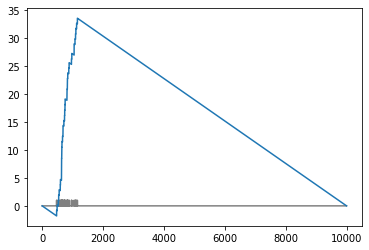

In [46]:
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

select = np.zeros(10000)
for i in range(len(select)):
    if random.uniform(0, 1) < 40*norm.pdf(i, loc=800, scale=200):
        select[i] = 1

fig, ax = plt.subplots()
ax.plot(range(len(select)), select, c="grey")
select = pd.Series(select, dtype="bool")

up = (~select).sum() / select.shape[0]
dn = -(1-up)
x = np.arange(select.shape[0]+1)
y = np.concatenate([
    np.zeros(1),
    np.cumsum(select.apply(lambda s: up if s else dn)),
    #np.cumsum(up+dn),
])

ax.plot(x, y)


In [47]:
import time

st = time.time()
for i in range(200):
    cs = np.cumsum(select.apply(lambda s: up if s else dn))
print(time.time()-st)

st = time.time()

for i in range(200):
    ups = select*up
    downs = ~select*dn
    cs = np.cumsum(ups+downs)
print(time.time()-st)

0.49199771881103516
0.08403325080871582
